In [1]:
#predict champagne sales
#observation are sales in million units

In [2]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt

series=Series.from_csv('champagne.csv')
split_point=len(series)-12
dataset,validation=series[0:split_point],series[split_point:]
print('Dataset %d, Validation %d' %(len(dataset),len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 93, Validation 12


In [3]:
# data prep
seriesDataset=Series.from_csv('dataset.csv')
X=seriesDataset.values
X=X.astype('float32')
train_size=int(len(X)*0.50)
train,test=X[0:train_size],X[train_size:]


In [4]:
#walk-forward validation
history=[x for x in train]
predictions=list()
for i in range(len(test)):
    #predict
    yhat=history[-1]
    predictions.append(yhat)
    
    #observation
    obs=test[i]
    history.append(obs)
    
    print('>Predicted=%.3f , Expected=%.3f' %(yhat,obs))

#report performance
mse=mean_squared_error(test,predictions)
rmse=sqrt(mse)
print ('RMSE : %.3f' %rmse)

>Predicted=5428.000 , Expected=8314.000
>Predicted=8314.000 , Expected=10651.000
>Predicted=10651.000 , Expected=3633.000
>Predicted=3633.000 , Expected=4292.000
>Predicted=4292.000 , Expected=4154.000
>Predicted=4154.000 , Expected=4121.000
>Predicted=4121.000 , Expected=4647.000
>Predicted=4647.000 , Expected=4753.000
>Predicted=4753.000 , Expected=3965.000
>Predicted=3965.000 , Expected=1723.000
>Predicted=1723.000 , Expected=5048.000
>Predicted=5048.000 , Expected=6922.000
>Predicted=6922.000 , Expected=9858.000
>Predicted=9858.000 , Expected=11331.000
>Predicted=11331.000 , Expected=4016.000
>Predicted=4016.000 , Expected=3957.000
>Predicted=3957.000 , Expected=4510.000
>Predicted=4510.000 , Expected=4276.000
>Predicted=4276.000 , Expected=4968.000
>Predicted=4968.000 , Expected=4677.000
>Predicted=4677.000 , Expected=3523.000
>Predicted=3523.000 , Expected=1821.000
>Predicted=1821.000 , Expected=5222.000
>Predicted=5222.000 , Expected=6872.000
>Predicted=6872.000 , Expected=10803

In [5]:
# data analysis / summary

#summary
print (seriesDataset.describe())

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
dtype: float64


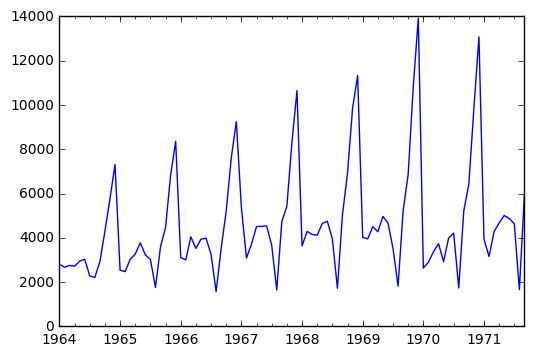

In [6]:
#line plot

from matplotlib import pyplot
seriesDataset.plot()
pyplot.show()

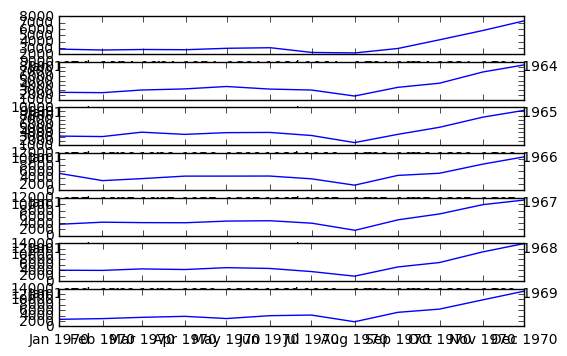

In [7]:
# seasonal line plots
from pandas import DataFrame
from pandas import TimeGrouper
groups=seriesDataset['1964':'1970'].groupby(TimeGrouper('A'))
years=DataFrame()
pyplot.figure 
i=1
n_groups=len(groups)
for name,group in groups:
    pyplot.subplot((n_groups*100) +10 +i)
    i+=1
    pyplot.plot(group)
pyplot.show()

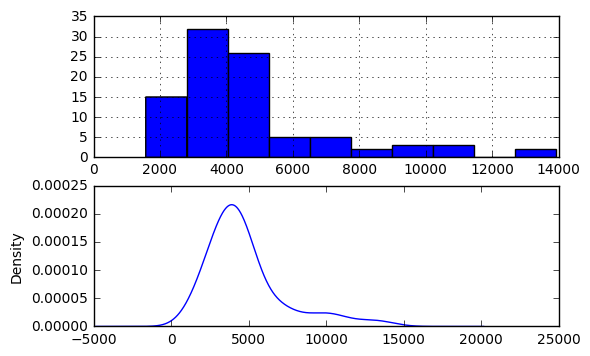

In [8]:
pyplot.figure(1)
pyplot.subplot(211)
seriesDataset.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

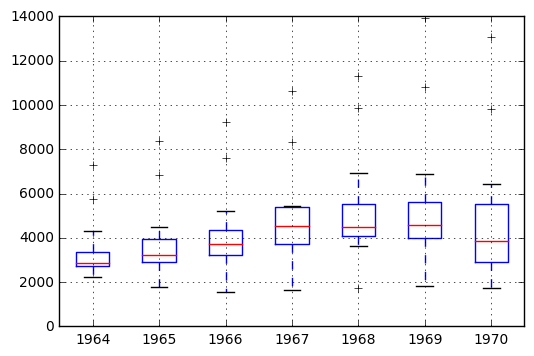

In [9]:
#box and whisker
for name,group in groups:
    years[name.year]=group.values
years.boxplot()
pyplot.show()
    

ADF statistic: -7.134898
p-value: 0.000000
Critical values:
	5%: -2.898
	1%: -3.515
	10%: -2.586


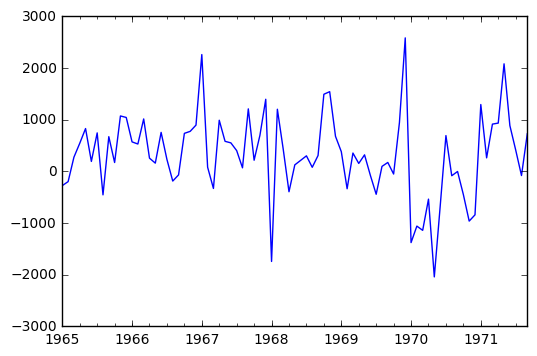

In [10]:
#ARIMA
#manually configure
#we need to make the time series
#deseasonalize it and save in stationary.csv
from statsmodels.tsa.stattools import adfuller

#create differenced series
def difference(dataset,interval=1):
    diff=list()
    for i in range(interval,len(dataset)):
        value=dataset[i]-dataset[i-interval]
        diff.append(value)
    return Series(diff)

#difference data
months_in_year=12
stationary=difference(X,months_in_year)
stationary.index=seriesDataset.index[months_in_year:]

#check if stationary
result=adfuller(stationary)
print('ADF statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')

for key,value in result[4].items():
    print('\t%s: %.3f' %(key,value))
    
#save
stationary.to_csv('stationary.csv')

#plot
stationary.plot()
pyplot.show()

In [11]:
# invert differenced value
def inverse_difference(history,yhat,interval=1):
    return yhat+history[-interval]


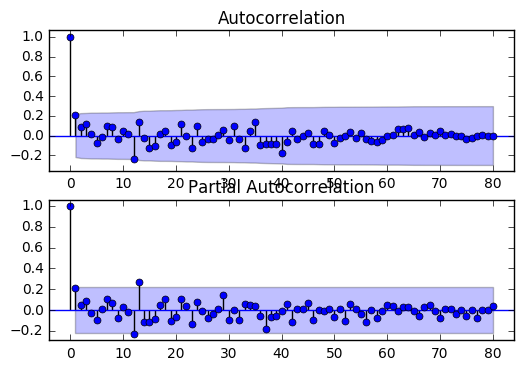

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

series=Series.from_csv('stationary.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series,ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series,ax=pyplot.gca())
pyplot.show()

In [14]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1,1,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=8089.831, Expected=8314
>Predicted=9742.725, Expected=10651
>Predicted=5986.916, Expected=3633
>Predicted=3887.016, Expected=4292
>Predicted=4038.090, Expected=4154
>Predicted=4992.344, Expected=4121
>Predicted=5156.511, Expected=4647
>Predicted=5046.684, Expected=4753
>Predicted=4143.828, Expected=3965
>Predicted=2102.971, Expected=1723
>Predicted=5228.274, Expected=5048
>Predicted=5873.380, Expected=6922
>Predicted=8571.267, Expected=9858
>Predicted=11006.081, Expected=11331
>Predicted=4087.508, Expected=4016
>Predicted=4771.840, Expected=3957
>Predicted=4676.134, Expected=4510
>Predicted=4583.387, Expected=4276
>Predicted=5117.355, Expected=4968
>Predicted=5208.150, Expected=4677
>Predicted=4436.458, Expected=3523
>Predicted=2180.970, Expected=1821
>Predicted=5471.232, Expected=5222
>Predicted=7337.611, Expected=6872
>Predicted=10268.406, Expected=10803
>Predicted=11725.313, Expected=13916
>Predicted=4519.449, Expected=2639
>Predicted=4606.075, Expected=2899
>Predicted=49

In [15]:
#grid search through various possible hyperparameter values


import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.786
ARIMA(0, 0, 5) RMSE=986.832
ARIMA(0, 0, 6) RMSE=1087.032
ARIMA(0, 1, 1) RMSE=958.297
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.955
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.965
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.631
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.939
ARIMA(3, 2, 0) RMSE=1244.846
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.254
ARIMA(4, 2, 0) RMSE=1227.556
ARIMA(4, 2, 1) RMSE=1055.487
ARIMA(5, 0, 0) RMSE=987.690
ARIMA(5, 1, 0) RMSE=1042.642
ARIMA(5, 1, 1) RMSE=1023.399
ARIMA(5, 2, 1) RMSE=1053.727
ARIMA(6, 0, 0) RMSE=996.466
ARIMA(6, 1, 0) RMSE=1018.211
ARIMA(6, 1, 1) RMSE=1023.763
Best ARIMA(0, 0, 1) RMSE=939.464


                 0
count    47.000000
mean   -104.245739
std     961.544084
min   -2353.915751
25%    -519.666933
50%    -178.828236
75%     364.951276
max    2190.686823


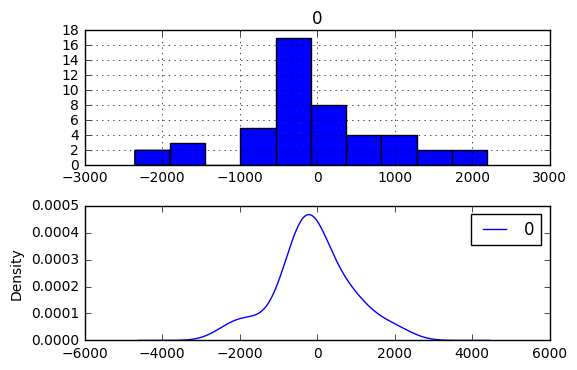

In [16]:
#check distribution og residual errors of ARIMA(0,0,1)

from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1,1,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

RMSE: 924.699
                 0
count    47.000000
mean      0.000016
std     934.696209
min   -2330.152177
25%    -455.556395
50%      25.854820
75%     567.087459
max    2201.400047


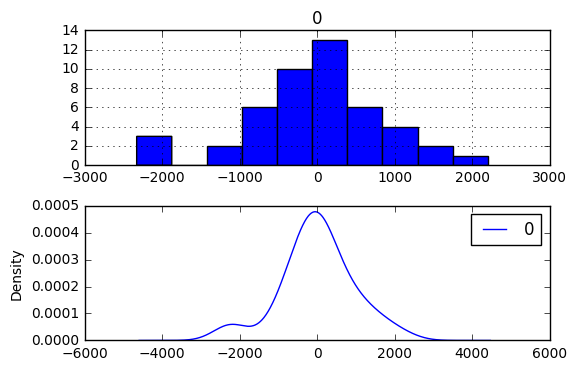

In [17]:
# add mean residual error for bias correction

from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.904728
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

                 0
count    47.000000
mean    165.904744
std     934.696209
min   -2164.247449
25%    -289.651667
50%     191.759548
75%     732.992187
max    2367.304775


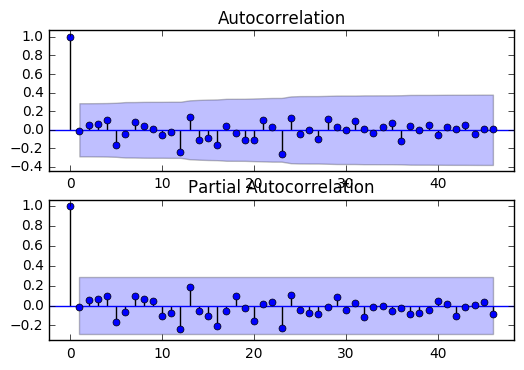

In [18]:
# ACF and PACF plots

from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [19]:
# finalize model

from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 165.904728
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [20]:
#make prediction

from pandas import Series
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = Series.from_csv('dataset.csv')
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 6794.773


>Predicted=6794.773, Expected=6981
>Predicted=10101.763, Expected=9851
>Predicted=13219.067, Expected=12670
>Predicted=3996.535, Expected=4348
>Predicted=3465.934, Expected=3564
>Predicted=4522.683, Expected=4577
>Predicted=4901.336, Expected=4788
>Predicted=5190.094, Expected=4618
>Predicted=4930.190, Expected=5312
>Predicted=4944.785, Expected=4298
>Predicted=1699.409, Expected=1413
>Predicted=6085.324, Expected=5877
RMSE: 361.110


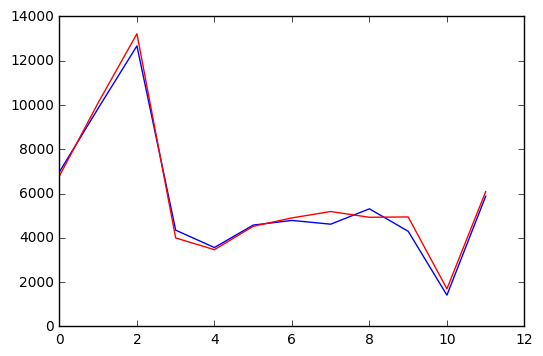

In [21]:
# validate the model

from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()